In [17]:
# used gymnasium instead of gym, couldnt get the version deconflict to work with newer version of numpy

import gymnasium as gym 
from gymnasium import logger as gymlogger
from gymnasium.wrappers import RecordVideo  

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque

import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay


In [18]:
import io
import base64
import glob
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0] 
        with open(mp4, "rb") as video_file:
            encoded = base64.b64encode(video_file.read()).decode('ascii') 


        ipythondisplay.display(HTML(f'''
            <video alt="test" autoplay loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{encoded}" type="video/mp4" />
            </video>
        '''))
    else: 
        print("Could not find a recorded video in ./video folder.")


Set initial environment for cartpole


In [19]:
env = gym.make("CartPole-v1")

Task 1: Developing a RL agent

In [ ]:
# I will be using Deep Q-Network agent.
# Below I will list down the definitions of the classes that I will be using.

# setting gpu to do RL
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Q Learning class
class QNetwork(nn.Module):
    #constructor for the network
    def __init__(self,state_dim,action_dim):
        super(QNetwork, self).__init__()
        # 3 layers of 'neurons' to map to all having 64 neurons
        # fc1 is the first layer and accepts state_dim as an input
        # it will then pass to fc2 then to fc3 to output as action_dim which are Q-values
        self.fc1 = nn.Linear(state_dim,64)
        self.fc2 = nn.Linear(64,64)
        self.fc3 = nn.Linear(64,action_dim)
    
    # 2 layers of ReLU activation which doesnt change positive outputs from the neurons
    # but changes negative outputs to 0
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)
    
class DQNAgent:
    #constructor for the agent
    def __init__(self, state_dim, action_dim, lr=0.001, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):

        # state_dim is the number of features in the state space == 4 because we have 4 variables that are in the environment
        self.state_dim = state_dim

        # action_dim is the number of actions we can take which is just 2, move left or move right
        self.action_dim = action_dim


        # just choose a high value for gamma,
        # which is how much the agent favors long-term rewards over immediate rewards
        # if i want the agent to be able to keep the stick from falling over in the future, ill set it high
        self.gamma = gamma

        # epsilon would the exploration rate
        # we set epsilon to be 1 at the start, because the agent hasnt learnt anything
        # so we want it to just explore randomly at first
        self.epsilon = epsilon

        # epsilon decay would be the decay rate for the exploration rate
        # the epsilon will decay so that the agent will use more of its memory instead of exploring randomly
        self.epsilon_decay = epsilon_decay

        # epsilon_min would be the minimum exploration rate after which it will not decay any further
        self.epsilon_min = epsilon_min

        self.memory = deque(maxlen=10000)
        self.batch_size = 64

        # create Q-Network
        # q_network will take in state_dim and pass it to GPU if possible to compute then output action_dim
        self.q_network = QNetwork(state_dim, action_dim).to(device)

        # this will take in the q_network and try to optimize it according to the input parameter of lr
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)

    def select_action(self, state):

        # this is how epsilon is used, if the random number generator outputs a number less than epsilon, it will just take a random action
        # if not, it will convert the state to a tensor and input its state to the q_network and get a q_value as a output to take action
        if np.random.rand() < self.epsilon:
            return random.choice(range(self.action_dim))
        else:
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            with torch.no_grad():
                q_values = self.q_network(state_tensor)
            return torch.argmax(q_values).item()

    # this function just stores memory of its previous actions
    def store_experience(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))



    def train(self):

        # only lets the agent train if the number of experiences > batchsize == 64
        # seems good to let the agent train on larger datasets
        if len(self.memory) < self.batch_size:
            return 

        # randomly uses a minibatch from memory
        minibatch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*minibatch)

        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones).to(device)

        # compute Q-values for current states
        q_values = self.q_network(states).gather(1, actions).squeeze(1)

        # compute target Q-values using Bellman equation
        with torch.no_grad():
            next_q_values = self.q_network(next_states).max(1)[0]
            target_q_values = rewards + (1 - dones) * self.gamma * next_q_values

        # compute loss and update network
        loss = F.mse_loss(q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # decay exploration rate
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

def train_dqn(episodes):
    env = gym.make("CartPole-v1")
    # env.observation_space is the format of the state the environment gives the agent at each step
    # each state comprises of cart position, cart velocity, pole angle, pole angular velocity
    # so env.observation_space.shape is (4,)
    # so state_dim = 4
    state_dim = env.observation_space.shape[0]

    # env.action_space tells us how many actions our agents can take
    # in this case its equal to 2 since the cart can only move left or right
    # .n gives the total number of actions which is 2
    action_dim = env.action_space.n

    # initialize the agent
    agent = DQNAgent(state_dim, action_dim)

    for episode in range(episodes):
        # reset environment to starting state for each episode
        state, _ = env.reset()
        total_reward = 0
        # flag to track whether each episode has ended
        done = False

        while not done:
            # let the agent choose the next action based on the current state
            action = agent.select_action(state)
            # environment responds to the action
            next_state, reward, terminated, truncated, _ = env.step(action)
            # mark episode as done or truncated if either is true
            done = terminated or truncated
            # store the experience
            agent.store_experience(state, action, reward, next_state, done)
            # use experience to train
            agent.train()
            # move to next state
            state = next_state
            # cumulative reward
            total_reward += reward

        print(f"Episode {episode + 1}: Total Reward = {total_reward:.2f}, Epsilon = {agent.epsilon:.3f}")

    env.close()

    #save the params of the trained model
    torch.save(agent.q_network.state_dict(), "q_network_trained.pth")


    return agent


# evaluate the trained agent for 100 episodes
def evaluate_agent_task2(agent, episodes,df):
    
    data = []


    env = gym.make("CartPole-v1", render_mode="human")  # render the environment
    for episode in range(episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            action = agent.select_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            state = next_state
            total_reward += reward

        data.append({"Episode":episode+1,"Total Reward":total_reward})
        print(f"Episode: {episode+1}")
    
    env.close()

    df = pd.concat([df,pd.DataFrame(data)], ignore_index = True)
    return df

def evaluate_agent_task1(agent):
    env = gym.make("CartPole-v1", render_mode="human")
    state, _ = env.reset()

    state += np.random.uniform(-0.2,0.2, size=state.shape)

    action = agent.select_action(state)
    print(f"State: {state}   Action:{action}")
    env.close()

def render_video(agent):
    env = gym.make("CartPole-v1" , render_mode="rgb_array")
    env = RecordVideo(env, "./video")
    state, _ = env.reset()
    done = False
    while not done:
        action = agent.select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        state = next_state

    env.close()
    show_video()

In [21]:
# Train the agent
dqn_agent = train_dqn(100)

Episode 1: Total Reward = 41.00, Epsilon = 1.000
Episode 2: Total Reward = 46.00, Epsilon = 0.887
Episode 3: Total Reward = 24.00, Epsilon = 0.786
Episode 4: Total Reward = 25.00, Epsilon = 0.694
Episode 5: Total Reward = 11.00, Epsilon = 0.656
Episode 6: Total Reward = 9.00, Epsilon = 0.627
Episode 7: Total Reward = 12.00, Epsilon = 0.591
Episode 8: Total Reward = 10.00, Epsilon = 0.562
Episode 9: Total Reward = 15.00, Epsilon = 0.521
Episode 10: Total Reward = 8.00, Epsilon = 0.501
Episode 11: Total Reward = 13.00, Epsilon = 0.469
Episode 12: Total Reward = 9.00, Epsilon = 0.448
Episode 13: Total Reward = 12.00, Epsilon = 0.422
Episode 14: Total Reward = 12.00, Epsilon = 0.398
Episode 15: Total Reward = 14.00, Epsilon = 0.371
Episode 16: Total Reward = 10.00, Epsilon = 0.353
Episode 17: Total Reward = 12.00, Epsilon = 0.332
Episode 18: Total Reward = 14.00, Epsilon = 0.309
Episode 19: Total Reward = 10.00, Epsilon = 0.294
Episode 20: Total Reward = 10.00, Epsilon = 0.280
Episode 21: 

Task 1 Inputting random environment and seeing how the agent will react

In [22]:
#input random environment and run agent
evaluate_agent_task1(dqn_agent)

State: [-0.06169856  0.09129121 -0.15877745 -0.17249097]   Action:0


Task 2: Running for 100 episodes and plotting results

In [23]:
# run agent for 100 episodes
df = pd.DataFrame(columns=["Episode","Total Reward"])
new_df = evaluate_agent_task2(dqn_agent, 100, df)
print(new_df)

Episode: 1
Episode: 2
Episode: 3
Episode: 4
Episode: 5
Episode: 6
Episode: 7
Episode: 8
Episode: 9
Episode: 10
Episode: 11
Episode: 12
Episode: 13
Episode: 14
Episode: 15
Episode: 16
Episode: 17
Episode: 18
Episode: 19
Episode: 20
Episode: 21
Episode: 22
Episode: 23
Episode: 24
Episode: 25
Episode: 26
Episode: 27
Episode: 28
Episode: 29
Episode: 30
Episode: 31
Episode: 32
Episode: 33
Episode: 34
Episode: 35
Episode: 36
Episode: 37
Episode: 38
Episode: 39
Episode: 40
Episode: 41
Episode: 42
Episode: 43
Episode: 44
Episode: 45
Episode: 46
Episode: 47
Episode: 48
Episode: 49
Episode: 50
Episode: 51
Episode: 52
Episode: 53
Episode: 54
Episode: 55
Episode: 56
Episode: 57
Episode: 58
Episode: 59
Episode: 60
Episode: 61
Episode: 62
Episode: 63
Episode: 64
Episode: 65
Episode: 66
Episode: 67
Episode: 68
Episode: 69
Episode: 70
Episode: 71
Episode: 72
Episode: 73
Episode: 74
Episode: 75
Episode: 76
Episode: 77
Episode: 78
Episode: 79
Episode: 80
Episode: 81
Episode: 82
Episode: 83
Episode: 84
E

D:\Temp\ipykernel_19080\2635887365.py:176: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,pd.DataFrame(data)], ignore_index = True)


D:\Temp\ipykernel_19080\499041883.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


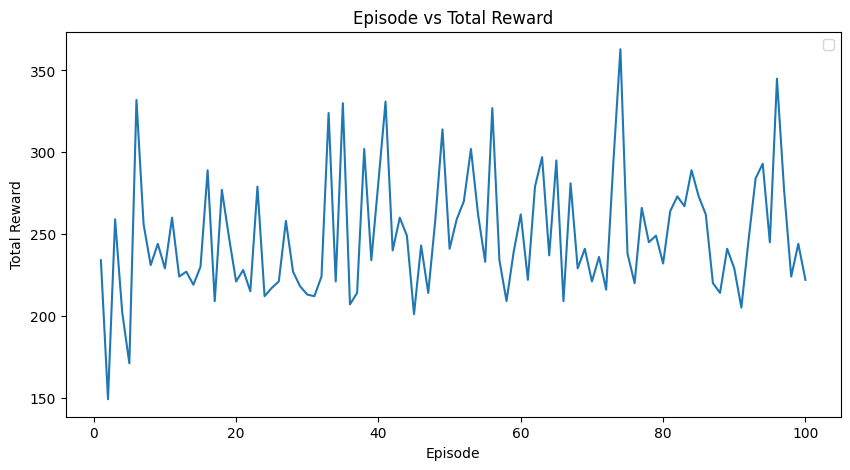

In [24]:
# plot Episode against Total Reward
plt.figure(figsize =(10,5))
plt.plot(new_df["Episode"],new_df["Total Reward"],linestyle='-')

plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Episode vs Total Reward")
plt.legend()

plt.show()

In [25]:
#calculate average reward

average_reward = new_df["Total Reward"].mean()
print(f"Average reward: {average_reward}")


Average reward: 248.84


Task 3: Render 1 episode played by agent

In [27]:
render_video(dqn_agent)

c:\Users\ethan\OneDrive\Documents\GitHub\SC3000-Assignment1\.venv\Lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at c:\Users\ethan\OneDrive\Documents\GitHub\SC3000-Assignment1\src\video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
